# Gravitational Wave sources, modeling and waveforms

This IPython notebook has some activities from the lecture on sources of gravitational waves, and how we model them. 

We will first look at how much energy is lost in GWs, specifically for the Earth-Sun system. 

Then, we will move onto modelling the gravitational waveform for a binary system of compact objects. We will define some python functions for the waveform, then further see how the masses of objects and the distance to the source affect the waveform. 

## Setup

Let's import some packages that we'll need as we move forward in the notebook.

In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
import scipy

%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.figsize'] = [8,6]
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['legend.fontsize'] = 12


# Exercise 1: Energy lost in gravitational waves

The power lost in gravitational waves as two objects orbit each other is given by

\begin{equation}
    \frac{dE}{dt} = P = \frac{32}{5} \frac{G^4}{c^5} \frac{m_1^2 m_2^2 (m_1 + m_2)}{r^5}
\end{equation}

Here $G = 6.7 \times 10^{-11} {\rm m^3 kg^{-1} s^{-2}}$ is the **Gravitational constant** and $c =  3 \times 10^8 {\rm m s^{-1}}$ is the **speed of light in vacuum**. 

Find the power lost in gravitational waves over time for the Earth-Sun orbit. Use

$r = 1.5 \times 10^{11} {\rm m}$

$m_{\rm sun} = 2 \times 10^{30} {\rm kg}$

$m_{\rm earth} = 6 \times 10^{24} {\rm kg}$.

**Step 1:** Define constants.

In [2]:
## Constants
G = 6.7e-11
c = 3e8
Msun = 2e30
Mpc = 3e22

**Step 2:** Write power as a function of the component masses and distance.

In [3]:
def power(m1, m2, r):
    ## Input masses in kilogram, and distance in metres. Outputs power in Watts.
    return (32./5.) * (G**4/c**5) * (m1**2 * m2**2 * (m1 + m2)/r**5)

**Step 3:** Compute the power for the Earth-Sun orbit.

In [4]:
power(2e30, 6e24, 1.5e11)

201.28453402341074

# Exercise 2: Visualising the Gravitational waveform

The gravitational waveform can be modelled as

\begin{equation}
    h_+(t) = 4 \frac{\mathcal{M}_s}{d_{\rm Ls}}(\pi \mathcal{M}_s f)^{2/3} cos \left[ -2 \left( \frac{T-t}{5\mathcal{M}_s}\right)^{5/8}\right]
\end{equation}

where,

\begin{eqnarray}
    f = \frac{1}{\pi \mathcal{M}_s} \left[\frac{5}{256} \frac{\mathcal{M}_s}{T - t}\right]^{3/8} \\
    \mathcal{M}_s = \mathcal{M} \left( \frac{G}{c^3}\right) \\
    \mathcal{M} = \frac{(m_1m_2)^{3/5}}{(m_1 + m_2)^{1/5}} \\
    d_{\rm Ls} = d_{\rm L}/c
\end{eqnarray}


$\mathcal{M}$ is called the chirp mass of a binary system. We use this combination of masses because this is how they appear in a lot of our calculations. 

The merger frequency for a coalescing binary can be approximated as 

\begin{equation}
    f_{\rm merger} = \frac{7000 {\rm Hz}}{(m_1 + m_2)/M_\odot}
\end{equation}

#### We will now plot the gravitational waveform for different systems and see how mass and distance affects the waveform.

### Step 0. Define some useful constants

In [5]:
## Constants
G = 6.7e-11
c = 3e8
Msun = 2e30 # mass of sun in Kg
Mpc = 3e22 # Mpc in meters (Mpc is a common astronomical distance measure)

### Step 1: Define some functions

Write up 3 functions:
1. `m_chirp(m1, m2)` which takes the component masses, $m_1$ and $m_2$, as inputs to compute the chirp mass, $\mathcal{M}$, of the binary system. 
2. `f_merger(m1, m2)` which takes the component masses, $m_1$ and $m_2$, as inputs and returns the merger frequency, $f_{\rm merger}$.
3. `h(m1, m2 , d, t)` which takes the component masses, $m_1$ and $m_2$, the distance to the source, $d$, and time, $t$ as inputs to return the strain $h_+(t)$. 

In defining `h(m1,m2,d,t)`, keep in mind:
- units of input quantities; units should be SI (kg, m, s, etc.)
- Detector sensitivity; our present detectors are sensitive within some frequency band which means the strain will be zero outside this frequency band. **To account for LIGO’s frequency response, set the waveform to zero below 30 Hz. Also set the waveform to zero above the merger frequency, $f_{\rm merger}$.**
- Use T = 10s (for illustration).

In [6]:
def m_chirp(m1, m2):
    return (m1*m2)**(3./5.) / (m1 + m2)**(1./5.)

def f_merger(m1, m2):
    return 7000./((m1 + m2)/ Msun)

def h(m1, m2 , dL, t):
    ## Input masses in solar masses, distance d in Mpc, and t in seconds.
    
    T = 10.
    
    # Compute chirp mass and change unit from kilogram to seconds.
    m = m_chirp(m1, m2)
    Ms = m * (G/c**3.) ## sec
    
    # Change the dL to seconds
    dLs = dL / c
    
    angle = -2. * ((T - t)/(5. * Ms)) ** (5./8.)
    
    # Compute frequency and merger frequency
    f = (1./(numpy.pi * Ms)) * (5. * Ms /(256. * (T - t)))**(3./8.)
    f_merge = f_merger(m1,m2)
    
    # compute the waveform
    h_plus = 4. * (Ms/dLs) * (numpy.pi * Ms * f) ** (2./3.) * numpy.cos(angle)
    
    # Introduce detector sensitivity and cut off after the merger frequency
    h_plus[f<30.] = 0.
    h_plus[f>f_merge] = 0.
        
    return h_plus

### Step  2: Generate the waveform

Using 100,000 samples starting at t = 0 sampled at 10,000 samples per second, generate $h_+(t)$ for $m_1 = 10 M_{\rm sun}$ and $m_2 = 3 M_{\rm sun}$ at $d = 25$ Mpc, and plot it. 

In [7]:
# Generate an time array starting at t = 0 upto t = T with 10,000 samples per second. 
t = numpy.linspace(0., 9.999, 100000)

Text(0, 0.5, 'Strain')

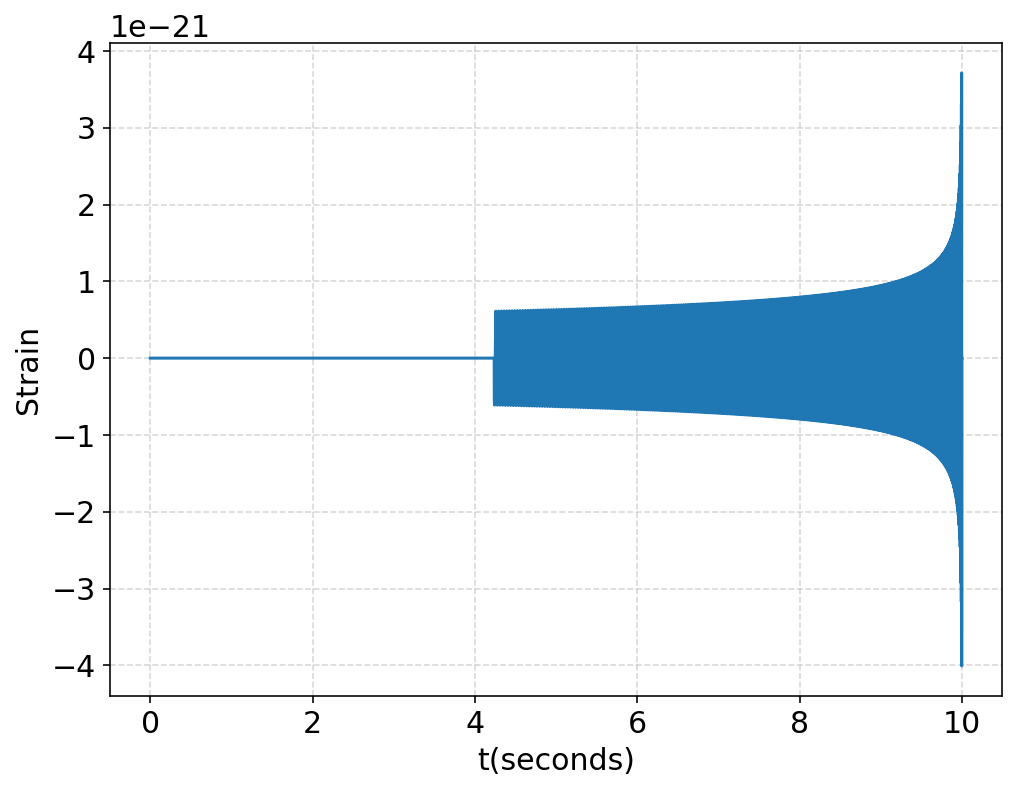

In [8]:
# Define m1, m2, d
m1 = 10. * Msun
m2 = 3. * Msun
d  = 25. * Mpc

# Generate an array of h(t) for the time array, t
h_of_t = h(m1, m2, d ,t) 

# Plot h(t) as a function of t
pyplot.plot(t, h_of_t)
pyplot.grid(True, ls='--', alpha=0.5)
pyplot.xlabel('t(seconds)')
pyplot.ylabel('Strain')

#### Let's see how masses and distance affect the waveform.

Visualize the waveform for different masses in the range of 1-100 $M_{\rm sun}$ and distances d in the range of 1-1000 Mpc.

### 1. How does it change as you vary mass?

- Define a mass array ranging from 1 to 100 $M_{\rm sun}$.
- Fix $d = 20$ Mpc.
- Write a for loop to input different masses from the array to compute $h_+(t)$ for the time array and plot it. Use the same value for $m_1$ and $m_2$

Text(0, 0.5, 'h(t)')

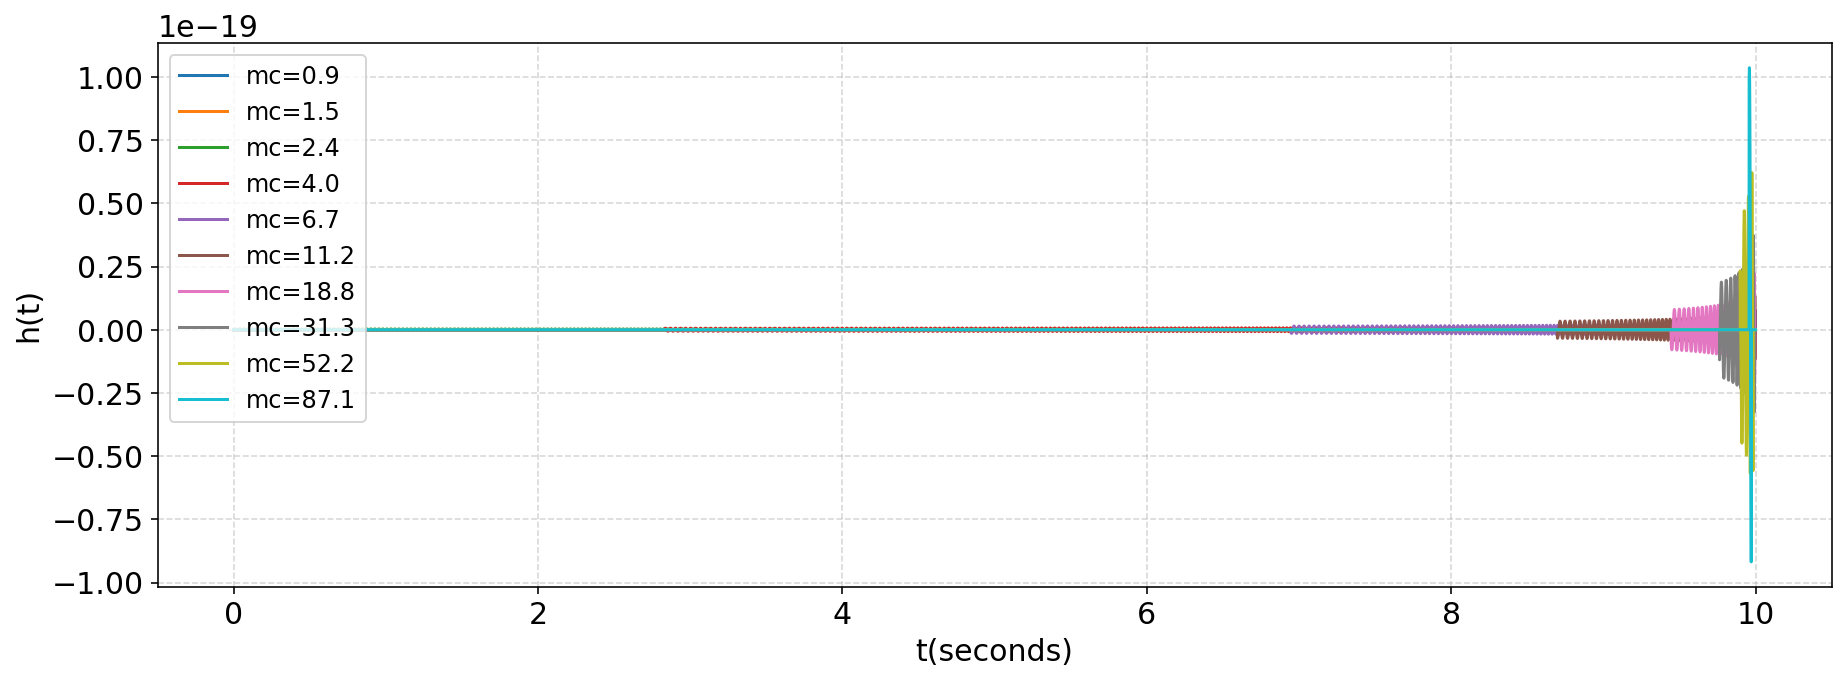

In [9]:
# Define mass and distance
mass    = numpy.logspace(0., 2., 10) * Msun
distance = 20. * Mpc

# Initialise plot
fig, ax = pyplot.subplots(figsize=(15,5))

# For loop to go over masses
for m in mass:
    m1=m2=m
    h_of_t = h(m1,m2,distance,t)
    m_c = m_chirp(m1,m2)
    # put masses back to Msun for readability
    ax.plot(t, h_of_t, label = "mc=%.1f" % (m_c/Msun))
    
pyplot.legend(loc='upper left')
pyplot.grid(True, ls='--', alpha=0.5)
pyplot.xlabel('t(seconds)')
pyplot.ylabel('h(t)')

#### Questions to ponder:

1. How does the amplitude of the waveform change with varying chirp mass, $\mathcal{M}$?
2. How does the chirp mass, $\mathcal{M}$ affect the duration of the GW signal?

### 2. How does it change as you vary distance?

- Define a distance array ranging from 1 to 1000 Mpc.
- Fix $m_1$ and $m_2$.
- Write a for loop to input different distance values from the array to compute $h_+(t)$ for the time array and plot it.

M_chirp:  3.3499379133114164 Solar Masses


Text(0, 0.5, 'h(t)')

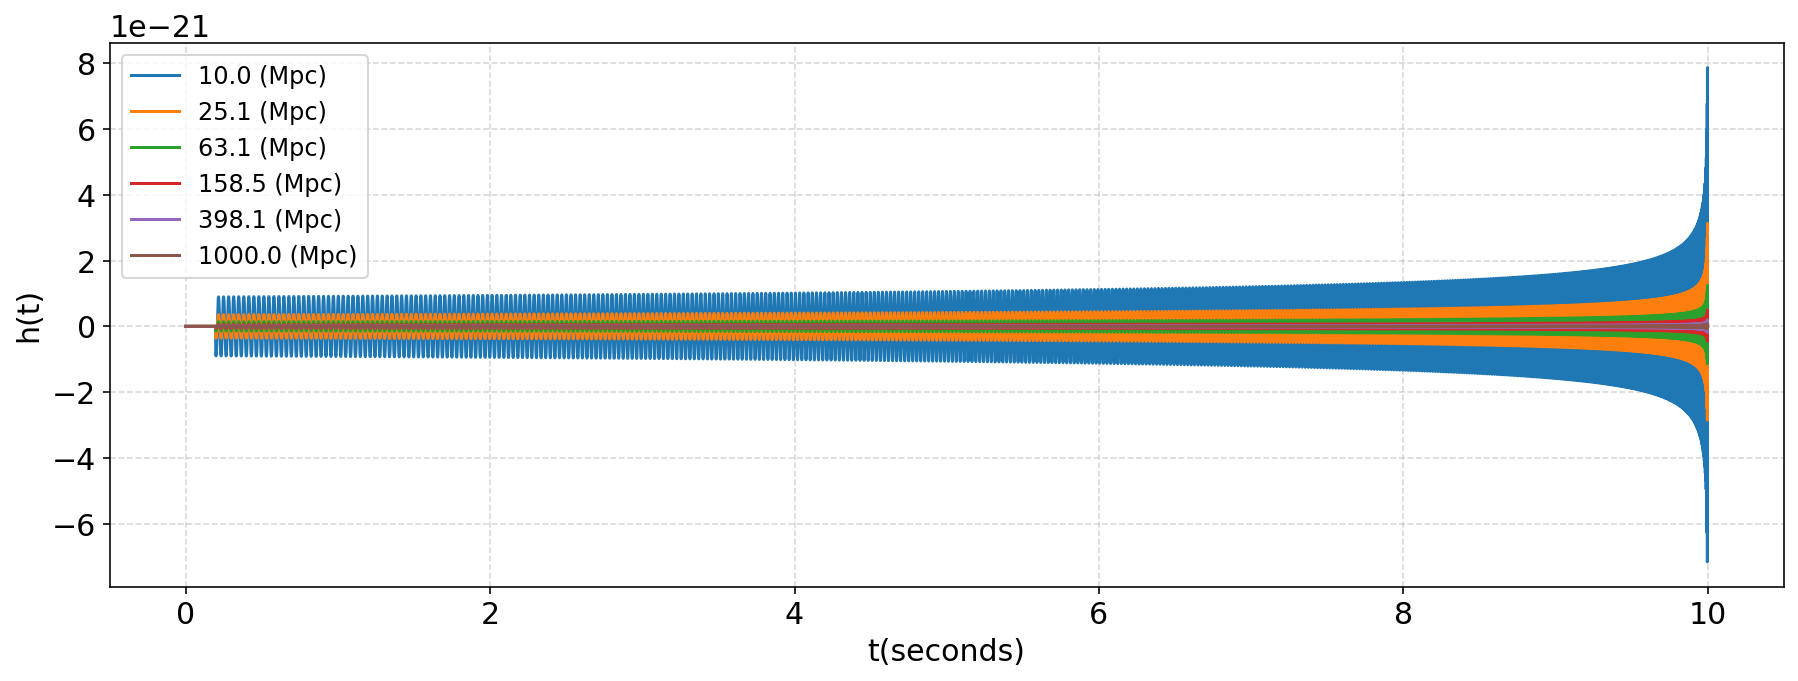

In [10]:
# Set masses and distance
mass1 = 5. * Msun
mass2 = 3. * Msun
 
print('M_chirp: ', m_chirp(mass1, mass2) / Msun, "Solar Masses")
distances = numpy.logspace(1., 3., 6) * Mpc

#Initialize the plot
fig, ax = pyplot.subplots(figsize=(15,5))

# For loop to go over distances
for i,d in enumerate(distances):
    h_of_t = h(mass1, mass2, d, t)
    
    ax.plot(t, h_of_t, label="%.1f (Mpc)" % (d / Mpc))
    
pyplot.legend()
pyplot.grid(True, ls='--', alpha=0.5)
pyplot.xlabel('t(seconds)')
pyplot.ylabel('h(t)')

#### Questions to ponder:

1. How does the amplitude of the waveform change with varying distance?
2. How does the distance affect the duration of the GW signal?

### 3. How does it change as you vary both mass and distance? Can you change the distance and mass while holding the peak amplitude constant? Can you infer the relationship?

\begin{equation}
    f \propto \mathcal{M}_s^{-5/8}
\end{equation}

so,
\begin{equation}
    h_+(t) \propto \mathcal{M}_s^{5/4}/d_{\rm L}
\end{equation}

If you hold the amplitude constant,

\begin{equation}
    \left(\frac{\mathcal{M}_1}{\mathcal{M}_2}\right)^{5/4} = \frac {d_{\rm L1}}{d_{\rm L2}}
\end{equation}

### 4. Compare the absolute value of Fourier Transform of $h_+(t)$ to $h^2(f) \propto f^{-7/6}$.

For a 5, 5 $M_{\rm sun}$ binary at 1 Mpc, compute the fourier transform of $h_+(t)$ using the `scipy` function called `scipy.fft.rfft`.

In [11]:
# Compute h_of_t for the system
h_of_t = h(5.*Msun, 5.*Msun, 1.*Mpc, t)

# Compute fourier transform of h_of_t
h_of_f = scipy.fft.rfft(h_of_t)

Plot the absolute value `abs()` of the amplitude of the Fourier Transform as a function of frequency on a log-log plot. Use an x-axis array defined as `f = 1 / T * numpy.arange(len(hf))`.

Compare $h(f)=3 \times 10^{-15}f^{-7/6} $ to this result. 

Note on a logarithmic plot, $y=x^n$ becomes the equation for a line with slope $n$.

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'h(f)')

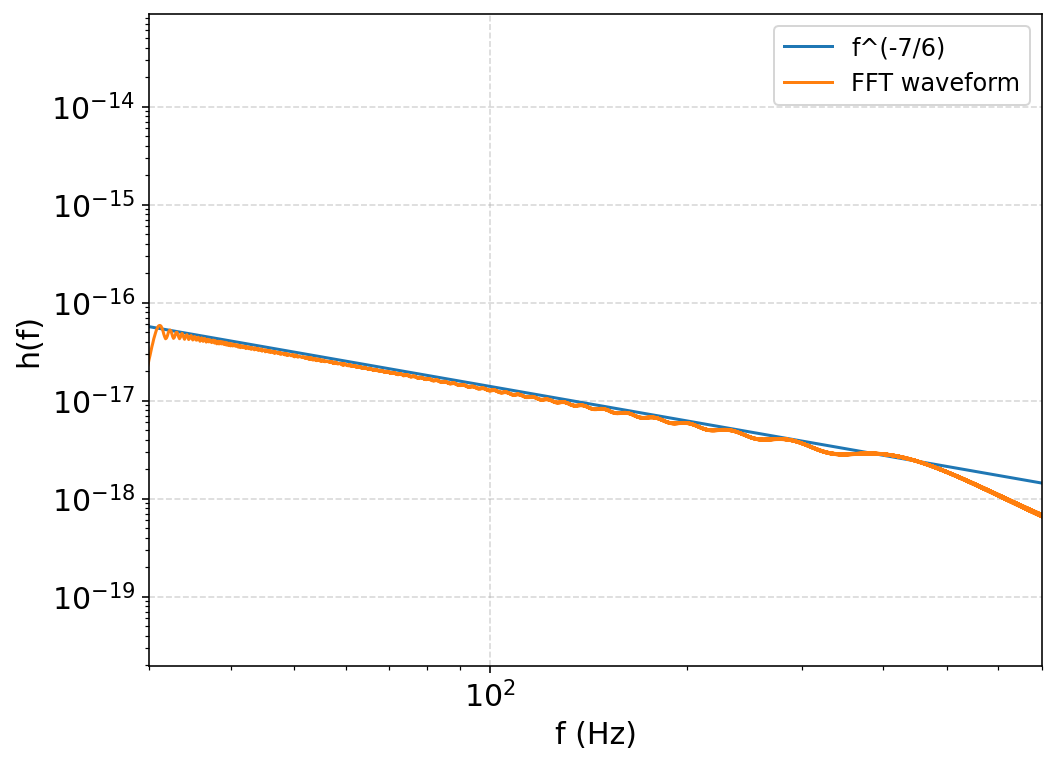

In [12]:
# Absolute value of the amplitude
abs_h_of_f = abs(h_of_f)

# Compute frequencies
f = 1 / 10. * numpy.arange(len(abs_h_of_f))

fmin = 30.
fmax = f_merger(5.*Msun,5.*Msun)

#Plot
pyplot.loglog(f, f**(-7./6.)*3e-15, label='f^(-7/6)')
pyplot.loglog(f, abs_h_of_f, label='FFT waveform')

pyplot.xlim([fmin, fmax])

pyplot.legend()
pyplot.grid(True, ls='--', alpha=0.5)
pyplot.xlabel('f (Hz)')
pyplot.ylabel('h(f)')